# Mount Google Drive

In [117]:
# from google.colab import drive
# drive.mount('/content/drive')


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Auto-detect project folder if name contains 'stat'
import os

base_candidates = []
for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if "stat" in root.lower():
        base_candidates.append(root)

print("Detected possible project locations:")
for p in base_candidates:
    print("  ->", p)


Mounted at /content/drive
Detected possible project locations:
  -> /content/drive/MyDrive/stat_arb_pairs
  -> /content/drive/MyDrive/stat_arb_pairs/data
  -> /content/drive/MyDrive/stat_arb_pairs/data/raw
  -> /content/drive/MyDrive/stat_arb_pairs/data/cleaned
  -> /content/drive/MyDrive/stat_arb_pairs/data/pairs
  -> /content/drive/MyDrive/stat_arb_pairs/reports


In [118]:
BASE_DIR = "/content/drive/MyDrive/stat_arb_pairs"


#1. Install & Import Libraries

In [119]:
!pip install yfinance pandas numpy --quiet


In [120]:
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


#2. Config: Universe, Paths and Dates

In [121]:
# 1) Asset universe (you can edit this later)
UNIVERSE = [
    # Index ETFs
    "SPY", "QQQ", "DIA",
    # Sector ETFs
    "XLF", "XLE", "XLK", "XLI", "XLP",
    # Large-cap stocks (good pairs candidates)
    "AAPL", "MSFT", "JPM", "BAC", "KO", "PEP", "XOM", "CVX",
]

# 2) Date range (last 5 years)
END_DATE = datetime.today()
START_DATE = END_DATE - timedelta(days=5 * 365)

# 3) Data folders (inside BASE_DIR defined earlier)
DATA_DIR_RAW = os.path.join(BASE_DIR, "data", "raw")
DATA_DIR_CLEANED = os.path.join(BASE_DIR, "data", "cleaned")

os.makedirs(DATA_DIR_RAW, exist_ok=True)
os.makedirs(DATA_DIR_CLEANED, exist_ok=True)

print("Base dir:", BASE_DIR)
print("Saving raw data to:", DATA_DIR_RAW)
print("Saving cleaned data to:", DATA_DIR_CLEANED)


Base dir: /content/drive/MyDrive/stat_arb_pairs
Saving raw data to: /content/drive/MyDrive/stat_arb_pairs/data/raw
Saving cleaned data to: /content/drive/MyDrive/stat_arb_pairs/data/cleaned


#3.Download Function

In [122]:
def download_price_data(tickers, start_date, end_date):
    """
    Download daily OHLCV data for a list of tickers using yfinance.
    Returns a long-format DataFrame: [date, ticker, open, high, low, close, adj_close, volume]
    """
    print(f"Downloading data for {len(tickers)} tickers from Yahoo Finance...")
    data = yf.download(
        tickers=tickers,
        start=start_date.strftime("%Y-%m-%d"),
        end=end_date.strftime("%Y-%m-%d"),
        auto_adjust=False,
        group_by="ticker",
        progress=True,
    )

    all_rows = []

    for ticker in tickers:
        if ticker not in data.columns.get_level_values(0):
            print(f"WARNING: No data for {ticker}, skipping.")
            continue

        df_t = data[ticker].copy()
        df_t["ticker"] = ticker
        df_t.rename(
            columns={
                "Open": "open",
                "High": "high",
                "Low": "low",
                "Close": "close",
                "Adj Close": "adj_close",
                "Volume": "volume",
            },
            inplace=True,
        )
        df_t.index.name = "date"
        all_rows.append(df_t.reset_index())

    if not all_rows:
        raise ValueError("No data downloaded for any ticker. Check ticker symbols or connection.")

    df_all = pd.concat(all_rows, axis=0, ignore_index=True)
    df_all.sort_values(["date", "ticker"], inplace=True)

    return df_all


#4. Cleaning + Aligning Function

In [123]:
def clean_and_align_data(df):
    """
    Clean the raw long-format DataFrame:
    - Keep adj_close only (for now)
    - Pivot to wide format with dates as index and tickers as columns
    - Forward-fill/back-fill gaps
    - Drop rows with any remaining NaNs
    - Compute log returns
    """
    print("Cleaning and aligning data...")

    df["date"] = pd.to_datetime(df["date"])
    df.sort_values(["date", "ticker"], inplace=True)

    # Wide format prices
    price_wide = df.pivot(index="date", columns="ticker", values="adj_close")

    # Fill gaps
    price_wide_ffill = price_wide.ffill().bfill()

    # Keep only rows where all tickers have data
    price_wide_cleaned = price_wide_ffill.dropna(how="any")

    # Log returns
    log_returns = np.log(price_wide_cleaned / price_wide_cleaned.shift(1))
    log_returns = log_returns.dropna(how="any")

    return price_wide_cleaned, log_returns


#5. Save to CSV

In [124]:
def save_data(raw_df, price_wide, log_returns):
    raw_path_csv = os.path.join(DATA_DIR_RAW, "prices_raw.csv")
    prices_csv = os.path.join(DATA_DIR_CLEANED, "adj_close_wide.csv")
    returns_csv = os.path.join(DATA_DIR_CLEANED, "log_returns_wide.csv")

    print(f"Saving raw data to: {raw_path_csv}")
    raw_df.to_csv(raw_path_csv, index=False)

    print(f"Saving cleaned price data to: {prices_csv}")
    price_wide.to_csv(prices_csv)

    print(f"Saving log returns to: {returns_csv}")
    log_returns.to_csv(returns_csv)


#6. Running Pipeline

In [125]:
print("=== STAT ARB DATA PIPELINE: STEP 1 (DOWNLOAD + CLEAN) ===")
print(f"Universe: {UNIVERSE}")
print(f"Date Range: {START_DATE.date()} to {END_DATE.date()}")

raw_df = download_price_data(UNIVERSE, START_DATE, END_DATE)
print("Downloaded rows:", len(raw_df))

prices_wide, log_returns = clean_and_align_data(raw_df)
print("Cleaned prices shape:", prices_wide.shape)
print("Log returns shape:", log_returns.shape)

save_data(raw_df, prices_wide, log_returns)

print("Done")


[*********             19%                       ]  3 of 16 completed

=== STAT ARB DATA PIPELINE: STEP 1 (DOWNLOAD + CLEAN) ===
Universe: ['SPY', 'QQQ', 'DIA', 'XLF', 'XLE', 'XLK', 'XLI', 'XLP', 'AAPL', 'MSFT', 'JPM', 'BAC', 'KO', 'PEP', 'XOM', 'CVX']
Date Range: 2020-12-05 to 2025-12-04


[*********************100%***********************]  16 of 16 completed


Downloaded rows: 20064
Cleaning and aligning data...
Cleaned prices shape: (1254, 16)
Log returns shape: (1253, 16)
Saving raw data to: /content/drive/MyDrive/stat_arb_pairs/data/raw/prices_raw.csv
Saving cleaned price data to: /content/drive/MyDrive/stat_arb_pairs/data/cleaned/adj_close_wide.csv
Saving log returns to: /content/drive/MyDrive/stat_arb_pairs/data/cleaned/log_returns_wide.csv
Done


# Pair selection & cointegration testing.
# Installing Extra Library

In [126]:
!pip install statsmodels --quiet


#1. Imports & Paths

In [127]:
import os
import itertools
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint


In [128]:
# Same base dir used earlier
# BASE_DIR = "/content/drive/MyDrive/stat_arb_pairs"

print("Base dir:", BASE_DIR)

DATA_DIR_CLEANED = os.path.join(BASE_DIR, "data", "cleaned")
OUTPUT_DIR = os.path.join(BASE_DIR, "data", "pairs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Cleaned data dir:", DATA_DIR_CLEANED)
print("Pairs output dir:", OUTPUT_DIR)


Base dir: /content/drive/MyDrive/stat_arb_pairs
Cleaned data dir: /content/drive/MyDrive/stat_arb_pairs/data/cleaned
Pairs output dir: /content/drive/MyDrive/stat_arb_pairs/data/pairs


#2. Load Cleaned Price Data

In [129]:
prices_path = os.path.join(DATA_DIR_CLEANED, "adj_close_wide.csv")
returns_path = os.path.join(DATA_DIR_CLEANED, "log_returns_wide.csv")

prices = pd.read_csv(prices_path, parse_dates=["date"], index_col="date")
log_returns = pd.read_csv(returns_path, parse_dates=["date"], index_col="date")

print("Prices shape:", prices.shape)
print("Log returns shape:", log_returns.shape)
display(prices.head())


Prices shape: (1254, 16)
Log returns shape: (1253, 16)


,AAPL,BAC,CVX,DIA,JPM,KO,MSFT,PEP,QQQ,SPY,XLE,XLF,XLI,XLK,XLP,XOM
date,,,,,,,,,,,,,,,,
2020-12-07,120.464714,25.914566,73.384430,275.692139,107.044014,45.589848,205.619736,125.814262,298.008087,344.088104,32.690292,26.347977,82.184105,121.461678,59.054981,33.427982
2020-12-08,121.078003,25.772032,74.015106,276.699371,107.149414,45.753304,207.270142,125.944084,299.016785,345.094971,33.176361,26.338827,82.582138,121.855659,59.379314,34.523182
2020-12-09,118.547028,25.656221,73.125702,275.490662,106.315048,45.882359,203.230499,126.091248,292.246704,341.999847,33.250511,26.274736,82.767273,119.520592,59.142635,34.980873
2020-12-10,119.968262,25.932381,75.478592,275.179413,105.629990,45.641460,202.002289,125.208466,293.420288,341.888031,34.272076,26.320513,81.980446,119.693565,58.879669,35.969818
2020-12-11,119.160301,25.451326,74.750877,275.536407,105.006416,45.899567,204.631454,125.468094,292.770447,341.487213,33.876633,26.055019,82.174828,119.443726,59.011158,35.798180


#3. Correlation Matrix & Candidate Pairs

In [130]:
def get_correlation_pairs(returns_df, min_corr=0.7):
    """
    Compute correlation matrix and return pairs with correlation >= min_corr.
    """
    corr_matrix = returns_df.corr()
    tickers = corr_matrix.columns

    pairs = []
    for i, j in itertools.combinations(tickers, 2):  # upper triangle only
        corr_val = corr_matrix.loc[i, j]
        if np.isnan(corr_val):
            continue
        if corr_val >= min_corr:
            pairs.append((i, j, corr_val))

    pairs_df = pd.DataFrame(pairs, columns=["asset_1", "asset_2", "corr"])
    pairs_df.sort_by = "corr"
    pairs_df = pairs_df.sort_values("corr", ascending=False).reset_index(drop=True)

    return corr_matrix, pairs_df

corr_matrix, candidate_pairs = get_correlation_pairs(log_returns, min_corr=0.7)

print("Total candidate pairs with corr >= 0.7:", len(candidate_pairs))
display(candidate_pairs.head(10))

# Save
candidate_pairs_path = os.path.join(OUTPUT_DIR, "candidate_pairs_corr.csv")
candidate_pairs.to_csv(candidate_pairs_path, index=False)
print("Saved candidate pairs to:", candidate_pairs_path)


Total candidate pairs with corr >= 0.7: 28


,asset_1,asset_2,corr
0,QQQ,XLK,0.971683
1,QQQ,SPY,0.945687
2,XLE,XOM,0.931558
3,SPY,XLK,0.927095
4,DIA,SPY,0.920672
5,CVX,XLE,0.912525
6,DIA,XLI,0.901376
7,DIA,XLF,0.879852
8,SPY,XLI,0.861392
9,BAC,XLF,0.861187


Saved candidate pairs to: /content/drive/MyDrive/stat_arb_pairs/data/pairs/candidate_pairs_corr.csv


#4. Cointegration Testing

In [131]:
def test_cointegration_for_pairs(prices_df, pairs_df, pvalue_thresh=0.05):
    """
    Run Engle-Granger cointegration test for candidate pairs.
    Returns a DataFrame of cointegrated pairs with stats.
    """
    results = []

    for idx, row in pairs_df.iterrows():
        asset_1 = row["asset_1"]
        asset_2 = row["asset_2"]
        corr_val = row["corr"]

        # Align and drop NaNs
        series_1 = prices_df[asset_1]
        series_2 = prices_df[asset_2]
        df_pair = pd.concat([series_1, series_2], axis=1).dropna()
        df_pair.columns = ["A", "B"]

        if df_pair.shape[0] < 100:  # require enough data points
            continue

        # Engle-Granger cointegration test
        try:
            coint_t, pvalue, crit_values = coint(df_pair["A"], df_pair["B"])
        except Exception as e:
            print(f"Error in coint test for {asset_1}-{asset_2}: {e}")
            continue

        # Hedge ratio via OLS: A ~ B
        try:
            X = sm.add_constant(df_pair["B"])
            model = sm.OLS(df_pair["A"], X).fit()
            hedge_ratio = model.params["B"]
            intercept = model.params["const"]
        except Exception as e:
            print(f"Error in OLS for {asset_1}-{asset_2}: {e}")
            continue

        # Save result
        results.append({
            "asset_1": asset_1,
            "asset_2": asset_2,
            "corr": corr_val,
            "pvalue": pvalue,
            "coint_t": coint_t,
            "crit_1pct": crit_values[0],
            "crit_5pct": crit_values[1],
            "crit_10pct": crit_values[2],
            "hedge_ratio": hedge_ratio,
            "intercept": intercept,
            "n_obs": df_pair.shape[0],
        })

    results_df = pd.DataFrame(results)
    if results_df.empty:
        print("No valid results from cointegration tests.")
        return results_df, results_df

    # Sort by p-value ascending (strongest first)
    results_df = results_df.sort_values("pvalue", ascending=True).reset_index(drop=True)

    # Filter to cointegrated
    coint_df = results_df[results_df["pvalue"] <= pvalue_thresh].reset_index(drop=True)

    return results_df, coint_df


In [132]:
all_coint_results, cointegrated_pairs = test_cointegration_for_pairs(
    prices_df=prices,
    pairs_df=candidate_pairs,
    pvalue_thresh=0.05
)

print("Total tested pairs:", len(all_coint_results))
print("Cointegrated pairs (p <= 0.05):", len(cointegrated_pairs))

display(cointegrated_pairs.head(10))


Total tested pairs: 28
Cointegrated pairs (p <= 0.05): 3


,asset_1,asset_2,corr,pvalue,coint_t,crit_1pct,crit_5pct,crit_10pct,hedge_ratio,intercept,n_obs
0,DIA,SPY,0.920672,0.016664,-3.731927,-3.905202,-3.341011,-3.047837,0.569911,88.729085,1254
1,DIA,XLK,0.766599,0.023273,-3.618001,-3.905202,-3.341011,-3.047837,1.110443,156.650774,1254
2,DIA,QQQ,0.780276,0.041150,-3.410940,-3.905202,-3.341011,-3.047837,0.543693,139.755254,1254


#5. Save Cointegrated Pairs

In [133]:
all_results_path = os.path.join(OUTPUT_DIR, "all_pairs_coint_results.csv")
coint_pairs_path = os.path.join(OUTPUT_DIR, "cointegrated_pairs.csv")

all_coint_results.to_csv(all_results_path, index=False)
cointegrated_pairs.to_csv(coint_pairs_path, index=False)

print("Saved all cointegration results to:", all_results_path)
print("Saved cointegrated pairs to:", coint_pairs_path)


Saved all cointegration results to: /content/drive/MyDrive/stat_arb_pairs/data/pairs/all_pairs_coint_results.csv
Saved cointegrated pairs to: /content/drive/MyDrive/stat_arb_pairs/data/pairs/cointegrated_pairs.csv


# spread + Z-score + signal generation + quick backtest
Paths

In [134]:
DATA_DIR_CLEANED = os.path.join(BASE_DIR, "data", "cleaned")
PAIRS_DIR = os.path.join(BASE_DIR, "data", "pairs")

prices_path = os.path.join(DATA_DIR_CLEANED, "adj_close_wide.csv")
prices = pd.read_csv(prices_path, parse_dates=["date"], index_col="date")

cointegrated_pairs_path = os.path.join(PAIRS_DIR, "cointegrated_pairs.csv")
cointegrated_pairs = pd.read_csv(cointegrated_pairs_path)

print("Prices shape:", prices.shape)
print("Cointegrated pairs found:", len(cointegrated_pairs))
display(cointegrated_pairs.head())

Prices shape: (1254, 16)
Cointegrated pairs found: 3


,asset_1,asset_2,corr,pvalue,coint_t,crit_1pct,crit_5pct,crit_10pct,hedge_ratio,intercept,n_obs
0,DIA,SPY,0.920672,0.016664,-3.731927,-3.905202,-3.341011,-3.047837,0.569911,88.729085,1254
1,DIA,XLK,0.766599,0.023273,-3.618001,-3.905202,-3.341011,-3.047837,1.110443,156.650774,1254
2,DIA,QQQ,0.780276,0.041150,-3.410940,-3.905202,-3.341011,-3.047837,0.543693,139.755254,1254


#1. Pick a Pair

In [135]:
# Pick top pair (change index 0 → 1, 2, ... to try others)
pair = cointegrated_pairs.iloc[0]

asset_1 = pair["asset_1"]
asset_2 = pair["asset_2"]
hedge_ratio = pair["hedge_ratio"]

print(f"Selected pair: {asset_1} vs {asset_2}, hedge_ratio = {hedge_ratio:.4f}")


Selected pair: DIA vs SPY, hedge_ratio = 0.5699


#2. Build Spread & Z-Score

In [136]:
def compute_spread_and_zscore(prices_df, asset_1, asset_2, hedge_ratio, window=60):
    """
    Build spread and z-score time series for a given pair.
    """
    df = prices_df[[asset_1, asset_2]].copy().dropna()
    df.columns = ["A", "B"]

    # Spread = A - β B
    df["spread"] = df["A"] - hedge_ratio * df["B"]

    # Rolling mean & std of spread
    df["spread_mean"] = df["spread"].rolling(window=window).mean()
    df["spread_std"] = df["spread"].rolling(window=window).std()

    # Z-score
    df["zscore"] = (df["spread"] - df["spread_mean"]) / df["spread_std"]

    df = df.dropna()  # drop initial window NaNs
    return df

spread_df = compute_spread_and_zscore(prices, asset_1, asset_2, hedge_ratio, window=60)
spread_df.tail()


,A,B,spread,spread_mean,spread_std,zscore
date,,,,,,
2025-11-26,474.350006,679.679993,86.993177,84.750921,2.217003,1.011390
2025-11-28,477.179993,683.390015,87.708783,84.777671,2.243132,1.306705
2025-12-01,473.320007,680.270020,85.626916,84.786097,2.245394,0.374464
2025-12-02,475.260010,681.530029,86.848825,84.809871,2.259751,0.902292
2025-12-03,479.410004,683.890015,89.653839,84.864572,2.336616,2.049659


#3. Generate Trading Signals from Z-Score

In [137]:
def generate_trading_signals(spread_df, entry_z=2.0, exit_z=0.5):
    """
    Generate long/short/flat signals from z-score.
    position = +1  → long spread (Long A, Short B)
    position = -1  → short spread (Short A, Long B)
    position = 0   → flat
    """
    df = spread_df.copy()
    position = 0
    positions = []

    for z in df["zscore"]:
        if position == 0:
            # No current position → look to enter
            if z > entry_z:
                position = -1  # short spread
            elif z < -entry_z:
                position = +1  # long spread
        else:
            # In a position → look to exit
            if abs(z) < exit_z:
                position = 0

        positions.append(position)

    df["position"] = positions

    # Human-readable signal
    df["signal"] = df["position"].map({
        1: "LONG_SPREAD (Long A, Short B)",
        -1: "SHORT_SPREAD (Short A, Long B)",
        0: "FLAT"
    })

    return df

signals_df = generate_trading_signals(spread_df, entry_z=2.0, exit_z=0.5)
signals_df.tail(10)


,A,B,spread,spread_mean,spread_std,zscore,position,signal
date,,,,,,,,
2025-11-19,461.179413,662.630005,83.539553,84.810961,2.236017,-0.568604,0,FLAT
2025-11-20,457.524017,652.530029,85.640240,84.796574,2.227705,0.378715,0,FLAT
2025-11-21,462.570007,659.030029,86.981811,84.813627,2.240630,0.967667,0,FLAT
2025-11-24,464.440002,668.729980,83.323701,84.744670,2.221353,-0.639686,0,FLAT
2025-11-25,471.179993,675.020020,86.478932,84.724172,2.199101,0.797944,0,FLAT
2025-11-26,474.350006,679.679993,86.993177,84.750921,2.217003,1.011390,0,FLAT
2025-11-28,477.179993,683.390015,87.708783,84.777671,2.243132,1.306705,0,FLAT
2025-12-01,473.320007,680.270020,85.626916,84.786097,2.245394,0.374464,0,FLAT
2025-12-02,475.260010,681.530029,86.848825,84.809871,2.259751,0.902292,0,FLAT


#4. Quick Visualization (Spread + Z-Score + Signals)

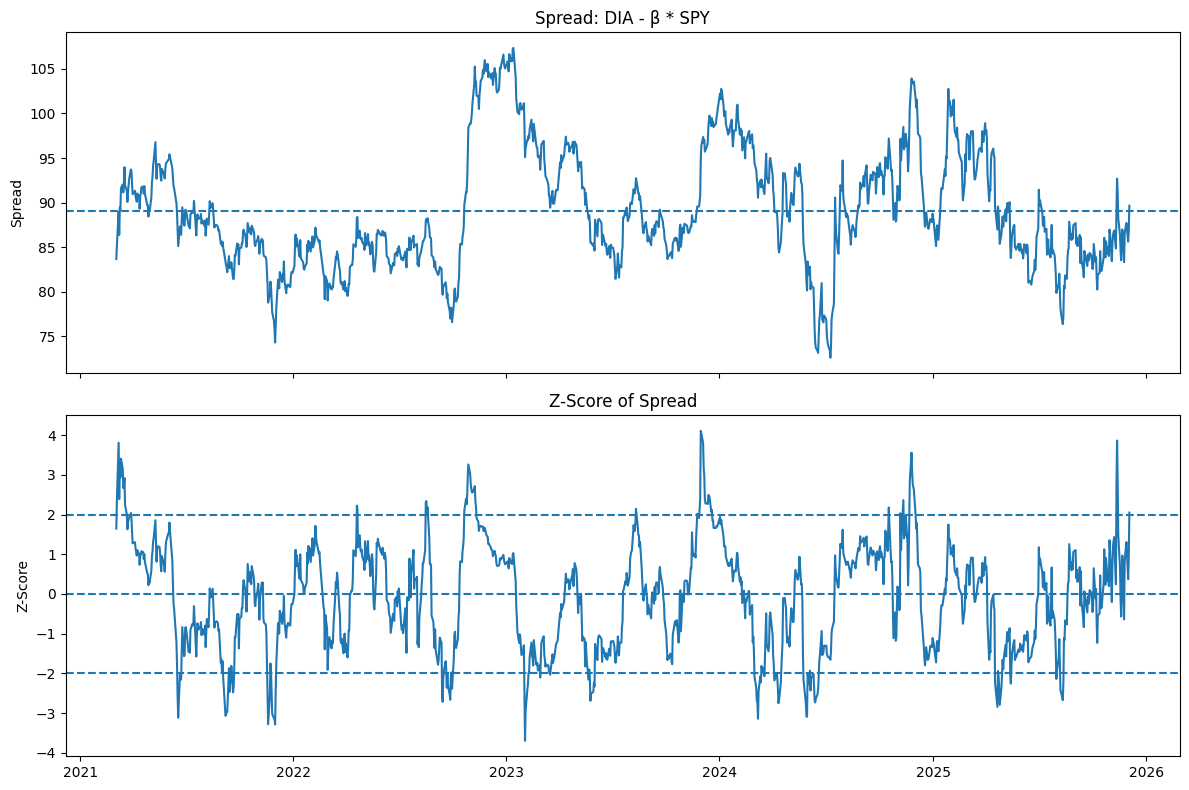

In [138]:
def plot_spread_and_zscore(df, asset_1, asset_2):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot spread
    axes[0].plot(df.index, df["spread"])
    axes[0].axhline(df["spread_mean"].mean(), linestyle="--")
    axes[0].set_title(f"Spread: {asset_1} - β * {asset_2}")
    axes[0].set_ylabel("Spread")

    # Plot z-score
    axes[1].plot(df.index, df["zscore"])
    axes[1].axhline(0, linestyle="--")
    axes[1].axhline(2, linestyle="--")
    axes[1].axhline(-2, linestyle="--")
    axes[1].set_title("Z-Score of Spread")
    axes[1].set_ylabel("Z-Score")

    plt.tight_layout()
    plt.show()

plot_spread_and_zscore(signals_df, asset_1, asset_2)


#5. Simple Backtest on This One Pair

In [139]:
def backtest_pair(prices_df, signals_df, asset_1, asset_2, hedge_ratio):
    # Align prices & signals
    df = pd.concat([
        prices_df[[asset_1, asset_2]],
        signals_df[["position"]]
    ], axis=1, join="inner").dropna()

    df.columns = ["A", "B", "position"]

    # Daily simple returns
    df["ret_A"] = df["A"].pct_change()
    df["ret_B"] = df["B"].pct_change()

    df = df.dropna()

    # Use previous day's position (no lookahead)
    df["position_shifted"] = df["position"].shift(1).fillna(0)

    # Portfolio return: long spread = long A, short β * B
    df["spread_ret"] = df["ret_A"] - hedge_ratio * df["ret_B"]
    df["strategy_ret"] = df["position_shifted"] * df["spread_ret"]

    # Equity curve
    df["equity_curve"] = (1 + df["strategy_ret"]).cumprod()

    # Stats
    total_return = df["equity_curve"].iloc[-1] - 1
    ann_factor = 252  # daily data
    ann_return = (1 + total_return) ** (ann_factor / len(df)) - 1
    ann_vol = df["strategy_ret"].std() * np.sqrt(ann_factor)
    sharpe = ann_return / ann_vol if ann_vol > 0 else np.nan
    max_dd = (df["equity_curve"].cummax() - df["equity_curve"]).max()

    stats = {
        "total_return": total_return,
        "annualized_return": ann_return,
        "annualized_vol": ann_vol,
        "sharpe_ratio": sharpe,
        "max_drawdown": max_dd,
        "num_trading_days": len(df),
    }

    return df, stats

bt_df, stats = backtest_pair(prices, signals_df, asset_1, asset_2, hedge_ratio)

print("Backtest stats:")
for k, v in stats.items():
    print(f"{k:20s} : {v:.4f}")


Backtest stats:
total_return         : 0.1151
annualized_return    : 0.0233
annualized_vol       : 0.0463
sharpe_ratio         : 0.5027
max_drawdown         : 0.1126
num_trading_days     : 1194.0000


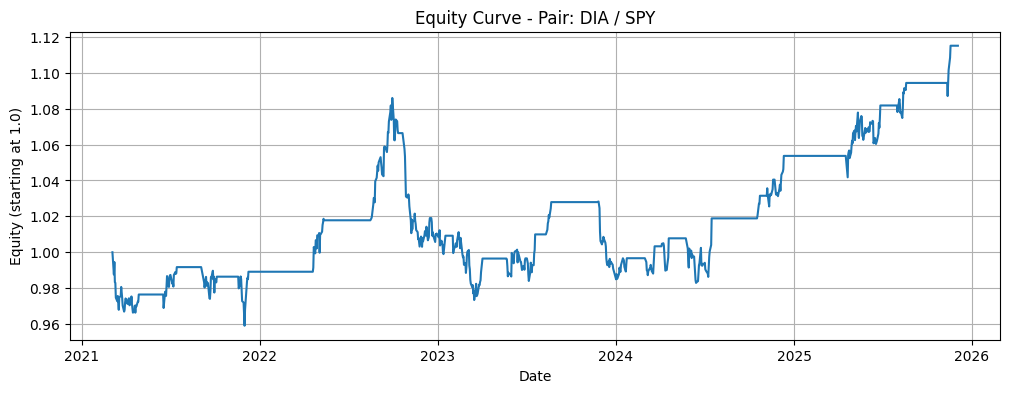

In [140]:
#Plot equity curve
plt.figure(figsize=(12, 4))
plt.plot(bt_df.index, bt_df["equity_curve"])
plt.title(f"Equity Curve - Pair: {asset_1} / {asset_2}")
plt.ylabel("Equity (starting at 1.0)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


#6. Loop Over All Cointegrated Pairs

In [141]:
pair_stats_list = []

for idx, row in cointegrated_pairs.iterrows():
    a1 = row["asset_1"]
    a2 = row["asset_2"]
    h = row["hedge_ratio"]

    try:
        spread_df = compute_spread_and_zscore(prices, a1, a2, h, window=60)
        signals_df = generate_trading_signals(spread_df, entry_z=2.0, exit_z=0.5)
        bt_df, stats = backtest_pair(prices, signals_df, a1, a2, h)
        stats["asset_1"] = a1
        stats["asset_2"] = a2
        stats["hedge_ratio"] = h
        pair_stats_list.append(stats)
    except Exception as e:
        print(f"Error processing pair {a1}-{a2}: {e}")
        continue

pair_stats_df = pd.DataFrame(pair_stats_list)
pair_stats_df = pair_stats_df.sort_values("sharpe_ratio", ascending=False)

pair_stats_df.head(10)


,total_return,annualized_return,annualized_vol,sharpe_ratio,max_drawdown,num_trading_days,asset_1,asset_2,hedge_ratio
2,0.329844,0.062011,0.065587,0.945465,0.092645,1194,DIA,QQQ,0.543693
0,0.115055,0.023251,0.046252,0.502702,0.112563,1194,DIA,SPY,0.569911
1,0.056816,0.011731,0.127613,0.091929,0.169998,1194,DIA,XLK,1.110443


In [142]:
#siving
pair_stats_path = os.path.join(PAIRS_DIR, "pair_backtest_stats.csv")
pair_stats_df.to_csv(pair_stats_path, index=False)
print("Saved pair backtest stats to:", pair_stats_path)


Saved pair backtest stats to: /content/drive/MyDrive/stat_arb_pairs/data/pairs/pair_backtest_stats.csv


# Backtrader in Colab – Single Pair Backtest
Installing and importing Backtrader

In [143]:
!pip install backtrader --quiet


In [144]:
import backtrader as bt

#1. Pick a pair and prepare OHLC data

In [145]:
DATA_DIR_CLEANED = os.path.join(BASE_DIR, "data", "cleaned")
PAIRS_DIR = os.path.join(BASE_DIR, "data", "pairs")

prices_path = os.path.join(DATA_DIR_CLEANED, "adj_close_wide.csv")
cointegrated_pairs_path = os.path.join(PAIRS_DIR, "cointegrated_pairs.csv")

prices = pd.read_csv(prices_path, parse_dates=["date"], index_col="date")
cointegrated_pairs = pd.read_csv(cointegrated_pairs_path)

print("Prices shape:", prices.shape)
print("Cointegrated pairs:", len(cointegrated_pairs))
cointegrated_pairs.head()

Prices shape: (1254, 16)
Cointegrated pairs: 3


,asset_1,asset_2,corr,pvalue,coint_t,crit_1pct,crit_5pct,crit_10pct,hedge_ratio,intercept,n_obs
0,DIA,SPY,0.920672,0.016664,-3.731927,-3.905202,-3.341011,-3.047837,0.569911,88.729085,1254
1,DIA,XLK,0.766599,0.023273,-3.618001,-3.905202,-3.341011,-3.047837,1.110443,156.650774,1254
2,DIA,QQQ,0.780276,0.041150,-3.410940,-3.905202,-3.341011,-3.047837,0.543693,139.755254,1254


In [146]:
# Pick strongest pair (first row)
pair = cointegrated_pairs.iloc[0]
asset_1 = pair["asset_1"]
asset_2 = pair["asset_2"]
hedge_ratio = pair["hedge_ratio"]

print(f"Selected pair: {asset_1} vs {asset_2}, hedge_ratio={hedge_ratio:.4f}")

# Build OHLCV from close-only (dummy but works for backtesting logic)
def make_ohlc_from_close(close_series):
    df = pd.DataFrame(index=close_series.index)
    df["close"] = close_series
    df["open"] = close_series
    df["high"] = close_series
    df["low"] = close_series
    df["volume"] = 1_000_000  # dummy volume
    return df

data_A = make_ohlc_from_close(prices[asset_1].dropna())
data_B = make_ohlc_from_close(prices[asset_2].dropna())

# Align dates
df_merged = data_A.join(data_B, lsuffix="_A", rsuffix="_B", how="inner")
df_merged.head()


Selected pair: DIA vs SPY, hedge_ratio=0.5699


,close_A,open_A,high_A,low_A,volume_A,close_B,open_B,high_B,low_B,volume_B
date,,,,,,,,,,
2020-12-07,275.692139,275.692139,275.692139,275.692139,1000000,344.088104,344.088104,344.088104,344.088104,1000000
2020-12-08,276.699371,276.699371,276.699371,276.699371,1000000,345.094971,345.094971,345.094971,345.094971,1000000
2020-12-09,275.490662,275.490662,275.490662,275.490662,1000000,341.999847,341.999847,341.999847,341.999847,1000000
2020-12-10,275.179413,275.179413,275.179413,275.179413,1000000,341.888031,341.888031,341.888031,341.888031,1000000
2020-12-11,275.536407,275.536407,275.536407,275.536407,1000000,341.487213,341.487213,341.487213,341.487213,1000000


#2. Creating Backtrader DataFeeds

In [147]:
# Data feed for asset A
data_feed_A = bt.feeds.PandasData(
    dataname=df_merged[["open_A", "high_A", "low_A", "close_A", "volume_A"]].rename(
        columns={
            "open_A": "open",
            "high_A": "high",
            "low_A": "low",
            "close_A": "close",
            "volume_A": "volume",
        }
    )
)

# Data feed for asset B
data_feed_B = bt.feeds.PandasData(
    dataname=df_merged[["open_B", "high_B", "low_B", "close_B", "volume_B"]].rename(
        columns={
            "open_B": "open",
            "high_B": "high",
            "low_B": "low",
            "close_B": "close",
            "volume_B": "volume",
        }
    )
)


#3. Defining a Cointegration/Z-Score Strategy in Backtrader

In [148]:
class PairTradingCointStrategy(bt.Strategy):
    params = dict(
        hedge_ratio=1.0,
        window=60,
        entry_z=2.0,
        exit_z=0.5,
        stake=100,       # number of shares for asset B; asset A sized by hedge_ratio
    )

    def __init__(self):
        # Two data feeds: data0 = A, data1 = B
        self.data_A = self.datas[0]
        self.data_B = self.datas[1]

        self.spread_buffer = []  # to store last N spreads

    def next(self):
        # Current prices
        price_A = self.data_A.close[0]
        price_B = self.data_B.close[0]

        # Update spread buffer
        spread = price_A - self.p.hedge_ratio * price_B
        self.spread_buffer.append(spread)

        if len(self.spread_buffer) < self.p.window:
            return  # not enough data yet

        # Keep only last window elements
        self.spread_buffer = self.spread_buffer[-self.p.window:]

        mean_spread = np.mean(self.spread_buffer)
        std_spread = np.std(self.spread_buffer)

        if std_spread == 0:
            return

        zscore = (spread - mean_spread) / std_spread

        # Current positions
        pos_A = self.getposition(self.data_A).size
        pos_B = self.getposition(self.data_B).size

        # --- Entry logic ---
        if pos_A == 0 and pos_B == 0:
            # No open position → can enter
            if zscore > self.p.entry_z:
                # Short spread: Short A, Long B
                size_B = self.p.stake
                size_A = -int(self.p.hedge_ratio * size_B)

                self.sell(data=self.data_A, size=abs(size_A))
                self.buy(data=self.data_B, size=size_B)

            elif zscore < -self.p.entry_z:
                # Long spread: Long A, Short B
                size_B = self.p.stake
                size_A = int(self.p.hedge_ratio * size_B)

                self.buy(data=self.data_A, size=size_A)
                self.sell(data=self.data_B, size=size_B)

        # --- Exit logic ---
        else:
            if abs(zscore) < self.p.exit_z:
                # Close both legs
                if pos_A > 0:
                    self.sell(data=self.data_A, size=pos_A)
                elif pos_A < 0:
                    self.buy(data=self.data_A, size=abs(pos_A))

                if pos_B > 0:
                    self.sell(data=self.data_B, size=pos_B)
                elif pos_B < 0:
                    self.buy(data=self.data_B, size=abs(pos_B))


#4. Running Backtest

In [149]:
cerebro = bt.Cerebro()

# Add data feeds in correct order (A = data0, B = data1)
cerebro.adddata(data_feed_A, name=asset_1)
cerebro.adddata(data_feed_B, name=asset_2)

# Add strategy
cerebro.addstrategy(
    PairTradingCointStrategy,
    hedge_ratio=hedge_ratio,
    window=60,
    entry_z=2.0,
    exit_z=0.5,
    stake=100
)

# Broker and commission
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0005)  # ~5 bps per trade

print("Starting Portfolio Value:", cerebro.broker.getvalue())
results = cerebro.run()
print("Final Portfolio Value:", cerebro.broker.getvalue())


Starting Portfolio Value: 100000.0
Final Portfolio Value: 86461.30892309571


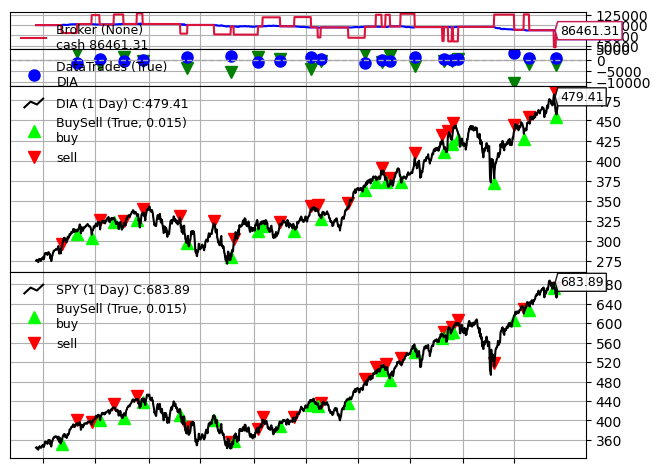

[[<Figure size 640x480 with 4 Axes>]]

In [150]:
cerebro.plot(iplot=False, volume=False)


#5. Add analyzers (Sharpe, Drawdown, Trades)

In [151]:
cerebro = bt.Cerebro()

cerebro.adddata(data_feed_A, name=asset_1)
cerebro.adddata(data_feed_B, name=asset_2)

cerebro.addstrategy(
    PairTradingCointStrategy,
    hedge_ratio=hedge_ratio,
    window=60,
    entry_z=2.0,
    exit_z=0.5,
    stake=100
)

cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0005)

# Analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="dd")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trades")

print("Starting Portfolio Value:", cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

print("Final Portfolio Value:", cerebro.broker.getvalue())
print("Sharpe:", strat.analyzers.sharpe.get_analysis())
print("Drawdown:", strat.analyzers.dd.get_analysis())
print("Trades:", strat.analyzers.trades.get_analysis())


Starting Portfolio Value: 100000.0
Final Portfolio Value: 86461.30892309571
Sharpe: OrderedDict({'sharperatio': -0.060201917214247946})
Drawdown: AutoOrderedDict({'len': 1003, 'drawdown': 16.487605904315615, 'moneydown': 17069.801469970742, 'max': AutoOrderedDict({'len': 1003, 'drawdown': 16.664582172639125, 'moneydown': 17253.026965698285})})
Trades: AutoOrderedDict({'total': AutoOrderedDict({'total': 40, 'open': 0, 'closed': 40}), 'streak': AutoOrderedDict({'won': AutoOrderedDict({'current': 0, 'longest': 3}), 'lost': AutoOrderedDict({'current': 1, 'longest': 2})}), 'pnl': AutoOrderedDict({'gross': AutoOrderedDict({'total': -12164.18041992187, 'average': -304.10451049804675}), 'net': AutoOrderedDict({'total': -13538.691076904295, 'average': -338.46727692260737})}), 'won': AutoOrderedDict({'total': 21, 'pnl': AutoOrderedDict({'total': 26574.086054565432, 'average': 1265.4326692650206, 'max': 3680.7347915649416})}), 'lost': AutoOrderedDict({'total': 19, 'pnl': AutoOrderedDict({'total':

# Multi-pair Backtrader strategy
Choose Top N Pairs

In [152]:
def select_top_non_overlapping_pairs(coint_df, max_pairs=5, sort_by="pvalue"):
    """
    Select top cointegrated pairs such that no ticker appears in more than one pair.
    sort_by: 'pvalue' (ascending) or 'corr' (descending)
    """
    if sort_by == "pvalue":
        df = coint_df.sort_values("pvalue", ascending=True).copy()
    elif sort_by == "corr":
        df = coint_df.sort_values("corr", ascending=False).copy()
    else:
        df = coint_df.copy()

    used_tickers = set()
    selected_rows = []

    for _, row in df.iterrows():
        a1, a2 = row["asset_1"], row["asset_2"]
        if a1 in used_tickers or a2 in used_tickers:
            continue
        selected_rows.append(row)
        used_tickers.add(a1)
        used_tickers.add(a2)
        if len(selected_rows) >= max_pairs:
            break

    return pd.DataFrame(selected_rows)

# Example: pick top 5 non-overlapping pairs
top_pairs = select_top_non_overlapping_pairs(cointegrated_pairs, max_pairs=3, sort_by="pvalue")

print("Selected pairs:")
display(top_pairs)


Selected pairs:


,asset_1,asset_2,corr,pvalue,coint_t,crit_1pct,crit_5pct,crit_10pct,hedge_ratio,intercept,n_obs
0,DIA,SPY,0.920672,0.016664,-3.731927,-3.905202,-3.341011,-3.047837,0.569911,88.729085,1254


#1. Building OHLC Data for All Tickers

In [153]:
def make_ohlc_from_close(close_series):
    df = pd.DataFrame(index=close_series.index)
    df["close"] = close_series
    df["open"] = close_series
    df["high"] = close_series
    df["low"] = close_series
    df["volume"] = 1_000_000  # dummy volume
    return df

# Get all unique tickers from selected pairs
tickers = sorted(set(top_pairs["asset_1"]).union(set(top_pairs["asset_2"])))
print("Tickers in multi-pair portfolio:", tickers)

# Build OHLC data for each
ohlc_dict = {}
for ticker in tickers:
    series = prices[ticker].dropna()
    ohlc_dict[ticker] = make_ohlc_from_close(series)

# Align dates across ALL tickers (inner join on index)
common_index = ohlc_dict[tickers[0]].index
for t in tickers[1:]:
    common_index = common_index.intersection(ohlc_dict[t].index)

for t in tickers:
    ohlc_dict[t] = ohlc_dict[t].loc[common_index]

print("Common date range:", common_index.min(), "to", common_index.max())


Tickers in multi-pair portfolio: ['DIA', 'SPY']
Common date range: 2020-12-07 00:00:00 to 2025-12-03 00:00:00


45

In [154]:
data_feeds = {}

for ticker in tickers:
    df_t = ohlc_dict[ticker].copy()
    df_t.columns = ["open", "high", "low", "close", "volume"]

    data_feed = bt.feeds.PandasData(dataname=df_t)
    data_feeds[ticker] = data_feed


#2. Multi-Pair Portfolio Strategy in Backtrader

In [155]:
class MultiPairStatArbStrategy(bt.Strategy):
    params = dict(
        pair_list=None,   # list of dicts: {"asset_1":..., "asset_2":..., "hedge_ratio":...}
        window=60,
        entry_z=2.0,
        exit_z=0.5,
        stop_z=4.0,
        stake=100,        # shares per "secondary" asset in each pair
    )

    def __init__(self):
        if self.p.pair_list is None:
            raise ValueError("pair_list param must be provided")

        # Map ticker name -> data feed object
        self.ticker_to_data = {d._name: d for d in self.datas}

        # Initialize per-pair state
        self.pairs = []
        for cfg in self.p.pair_list:
            a1 = cfg["asset_1"]
            a2 = cfg["asset_2"]
            h  = cfg["hedge_ratio"]

            if a1 not in self.ticker_to_data or a2 not in self.ticker_to_data:
                print(f"[WARN] Missing data for pair {a1}-{a2}, skipping.")
                continue

            self.pairs.append({
                "asset_1": a1,
                "asset_2": a2,
                "hedge_ratio": h,
                "data_A": self.getdatabyname(a1),
                "data_B": self.getdatabyname(a2),
                "spread_buffer": [],
                "state": 0,   # 0=flat, +1=long spread, -1=short spread
            })

        print(f"Initialized strategy with {len(self.pairs)} pairs.")

    def next(self):
        for pair in self.pairs:
            data_A = pair["data_A"]
            data_B = pair["data_B"]
            h = pair["hedge_ratio"]

            # Skip if any data not ready
            if len(data_A) == 0 or len(data_B) == 0:
                continue

            price_A = data_A.close[0]
            price_B = data_B.close[0]

            # Update spread buffer
            spread = price_A - h * price_B
            pair["spread_buffer"].append(spread)

            if len(pair["spread_buffer"]) < self.p.window:
                continue

            # Keep last window
            buf = pair["spread_buffer"][-self.p.window:]
            mean_spread = np.mean(buf)
            std_spread = np.std(buf)
            if std_spread == 0:
                continue

            z = (spread - mean_spread) / std_spread
            state = pair["state"]

            pos_A = self.getposition(data_A).size
            pos_B = self.getposition(data_B).size

            # --- Entry logic (flat → position) ---
            if state == 0 and pos_A == 0 and pos_B == 0:
                if z > self.p.entry_z:
                    # Short spread: Short A, Long B
                    size_B = self.p.stake
                    size_A = -int(h * size_B)

                    # Execute
                    self.sell(data=data_A, size=abs(size_A))
                    self.buy(data=data_B, size=size_B)

                    pair["state"] = -1

                elif z < -self.p.entry_z:
                    # Long spread: Long A, Short B
                    size_B = self.p.stake
                    size_A = int(h * size_B)

                    self.buy(data=data_A, size=size_A)
                    self.sell(data=data_B, size=size_B)

                    pair["state"] = +1

            # --- Exit logic (position → flat) ---
            elif state != 0:
                  # EXIT if mean-reverted OR if we hit stop_z in wrong direction
                  if abs(z) < self.p.exit_z or abs(z) > self.p.stop_z:
                      # Close both legs
                      if pos_A > 0:
                        self.sell(data=data_A, size=pos_A)
                      elif pos_A < 0:
                        self.buy(data=data_A, size=abs(pos_A))

                      if pos_B > 0:
                         self.sell(data=data_B, size=pos_B)
                      elif pos_B < 0:
                         self.buy(data=data_B, size=abs(pos_B))

                      pair["state"] = 0


#3. Building pair_list and Run Portfolio Backtest

In [156]:
# Build pair_list from selected top_pairs DataFrame
pair_list = []
for _, row in top_pairs.iterrows():
    pair_list.append({
        "asset_1": row["asset_1"],
        "asset_2": row["asset_2"],
        "hedge_ratio": row["hedge_ratio"],
    })

pair_list


[{'asset_1': 'DIA', 'asset_2': 'SPY', 'hedge_ratio': 0.5699105948897205}]

In [164]:
cerebro = bt.Cerebro()

# Add data feeds, and give them names = ticker
for ticker, data_feed in data_feeds.items():
    cerebro.adddata(data_feed, name=ticker)

# Add strategy
cerebro.addstrategy(
    MultiPairStatArbStrategy,
    pair_list=pair_list,
    window=60,
    entry_z=2.0,
    exit_z=0.5,
    stake=50,        # reduce stake per pair when trading multiple pairs
)

# Broker setup
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0005)  # 5 bps

# Analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="dd")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trades")

print("Starting Portfolio Value:", cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]
print("Final Portfolio Value:", cerebro.broker.getvalue())

print("\nSharpe:", strat.analyzers.sharpe.get_analysis())
print("\nDrawdown:", strat.analyzers.dd.get_analysis())
print("\nTrades:")
print(strat.analyzers.trades.get_analysis())


Starting Portfolio Value: 100000.0
Initialized strategy with 1 pairs.
Final Portfolio Value: 93304.85163925169

Sharpe: OrderedDict({'sharperatio': -0.05893772861145021})

Drawdown: AutoOrderedDict({'len': 1003, 'drawdown': 8.313916767753, 'moneydown': 8460.703557281508, 'max': AutoOrderedDict({'len': 1003, 'drawdown': 8.403940103926868, 'moneydown': 8552.316305145287})})

Trades:
AutoOrderedDict({'total': AutoOrderedDict({'total': 42, 'open': 0, 'closed': 42}), 'streak': AutoOrderedDict({'won': AutoOrderedDict({'current': 0, 'longest': 3}), 'lost': AutoOrderedDict({'current': 1, 'longest': 2})}), 'pnl': AutoOrderedDict({'gross': AutoOrderedDict({'total': -5975.739562988281, 'average': -142.27951340448288}), 'net': AutoOrderedDict({'total': -6695.148360748293, 'average': -159.4082943035308})}), 'won': AutoOrderedDict({'total': 22, 'pnl': AutoOrderedDict({'total': 13382.191810394284, 'average': 608.2814459270129, 'max': 1840.3673957824708})}), 'lost': AutoOrderedDict({'total': 20, 'pnl'

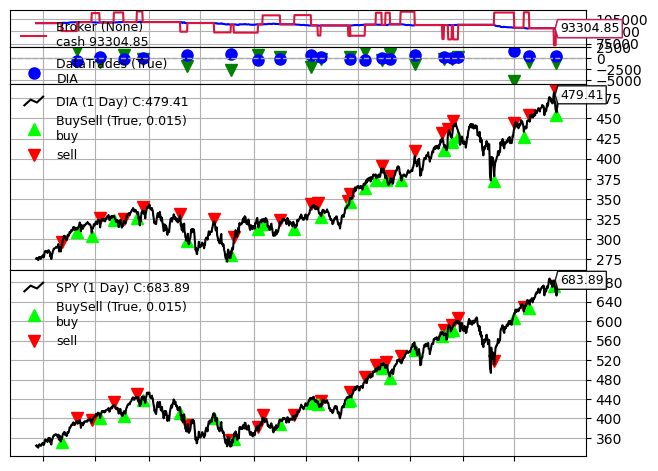

[[<Figure size 640x480 with 4 Axes>]]

In [165]:
#Ploting
cerebro.plot(iplot=False, volume=False)


#4. Exporting Portfolio Equity Curve & Daily Returns

In [166]:
# Re-run with TimeReturn analyzer to get daily returns
cerebro = bt.Cerebro()

for ticker, data_feed in data_feeds.items():
    cerebro.adddata(data_feed, name=ticker)

cerebro.addstrategy(
    MultiPairStatArbStrategy,
    pair_list=pair_list,
    window=45,
    entry_z=2.5,
    exit_z=0.5,
    stake=50,
)

cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.0)

cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="timereturn", timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="dd")
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trades")

results = cerebro.run()
strat = results[0]

# Pandas series of daily returns
ret_series = pd.Series(strat.analyzers.timereturn.get_analysis())
equity_curve = (1 + ret_series).cumprod() * 100000.0

portfolio_df = pd.DataFrame({
    "return": ret_series,
    "equity": equity_curve,
})
portfolio_df.head()


Initialized strategy with 1 pairs.


,return,equity
2020-12-07,0.0,100000.0
2020-12-08,0.0,100000.0
2020-12-09,0.0,100000.0
2020-12-10,0.0,100000.0
2020-12-11,0.0,100000.0


In [167]:
#saving
REPORT_DIR = os.path.join(BASE_DIR, "reports")
os.makedirs(REPORT_DIR, exist_ok=True)

portfolio_path = os.path.join(REPORT_DIR, "portfolio_equity_curve.csv")
portfolio_df.to_csv(portfolio_path)
print("Saved portfolio equity curve to:", portfolio_path)


Saved portfolio equity curve to: /content/drive/MyDrive/stat_arb_pairs/reports/portfolio_equity_curve.csv


In [168]:
print("Final Portfolio Value:", cerebro.broker.getvalue())
print("Sharpe:", strat.analyzers.sharpe.get_analysis())
print("Drawdown:", strat.analyzers.dd.get_analysis())
print("Trades:", strat.analyzers.trades.get_analysis())


Final Portfolio Value: 92675.82238769531
Sharpe: OrderedDict({'sharperatio': -0.06516254681526126})
Drawdown: AutoOrderedDict({'len': 935, 'drawdown': 8.794954715009228, 'moneydown': 8936.782592773438, 'max': AutoOrderedDict({'len': 935, 'drawdown': 8.90777045257216, 'moneydown': 9051.417602539062})})
Trades: AutoOrderedDict({'total': AutoOrderedDict({'total': 38, 'open': 0, 'closed': 38}), 'streak': AutoOrderedDict({'won': AutoOrderedDict({'current': 0, 'longest': 5}), 'lost': AutoOrderedDict({'current': 1, 'longest': 2})}), 'pnl': AutoOrderedDict({'gross': AutoOrderedDict({'total': -7324.17761230469, 'average': -192.74151611328134}), 'net': AutoOrderedDict({'total': -7324.17761230469, 'average': -192.74151611328134})}), 'won': AutoOrderedDict({'total': 22, 'pnl': AutoOrderedDict({'total': 10529.457763671877, 'average': 478.61171653053987, 'max': 1397.63818359375})}), 'lost': AutoOrderedDict({'total': 16, 'pnl': AutoOrderedDict({'total': -17853.63537597657, 'average': -1115.8522109985